In [ ]:
#%pip install opencv-python mediapipe albumentations matplotlib

#if you're using a virtual env please make sure you install the libraries above. Else if want to install globally uncomment the code above and run it to install the libraries

#This is for creating the dataset, so there is no need to run it.

In [36]:
import numpy as np
import cv2
import os
import mediapipe as mp
import matplotlib.pyplot as plt
import albumentations as A

In [37]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [38]:
def mediapipe_detection(input_image, model):
    # Convert image from BGR to RGB
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    # Make prediction
    detection_results = model.process(input_image)
    # Convert image back to BGR
    input_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2BGR)

    return input_image, detection_results

In [39]:
def draw_landmarks(input_image, detection_results):
    # Draw face connections
    mp_drawing.draw_landmarks(input_image, detection_results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    
    # Draw pose connections
    mp_drawing.draw_landmarks(input_image, detection_results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    
    # Draw left hand connections
    mp_drawing.draw_landmarks(input_image, detection_results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    
    # Draw right hand connections
    mp_drawing.draw_landmarks(input_image, detection_results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [40]:
def draw_styled_landmarks(input_image, detection_results):
    # Set drawing specifications for face connections
    face_points = mp_drawing.DrawingSpec(color=(0,0,0), thickness=1, circle_radius=1) 
    face_lines = mp_drawing.DrawingSpec(color=(255,255,255), thickness=1, circle_radius=1)

    # Set drawing specifications for pose connections
    pose_points = mp_drawing.DrawingSpec(color=(0,0,0), thickness=1, circle_radius=2)
    pose_lines = mp_drawing.DrawingSpec(color=(255,255,255), thickness=1, circle_radius=2)

    # Set drawing specifications for left hand connections
    left_hand_points = mp_drawing.DrawingSpec(color=(0,0,0), thickness=1, circle_radius=2)
    left_hand_lines = mp_drawing.DrawingSpec(color=(255,255,255), thickness=1, circle_radius=2)

    # Set drawing specifications for right hand connections
    right_hand_points = mp_drawing.DrawingSpec(color=(0,0,0), thickness=1, circle_radius=2)
    right_hand_lines = mp_drawing.DrawingSpec(color=(255,255,255), thickness=1, circle_radius=2)

    # Draw face connections
    mp_drawing.draw_landmarks(input_image, detection_results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, face_points, face_lines)

    # Draw pose connections
    mp_drawing.draw_landmarks(input_image, detection_results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, pose_points, pose_lines)

    # Draw left hand connections
    mp_drawing.draw_landmarks(input_image, detection_results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, left_hand_points, left_hand_lines)

    # Draw right hand connections
    mp_drawing.draw_landmarks(input_image, detection_results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, right_hand_points, right_hand_lines)

In [41]:
# Extract keypoints into flattened arrays
def extract_keypoints (detection_results):
    pose = np.array([[results.x, results.y, results.z, results.visibility]
    for results in detection_results.pose_landmarks.landmark]).flatten() if detection_results.pose_landmarks else np.zeros(33*4)

    face = np.array([[results.x, results.y, results.z]
    for results in detection_results.face_landmarks.landmark]).flatten() if detection_results.face_landmarks else np.zeros(468*3)

    left_hand = np.array([[results.x, results.y, results.z]
    for results in detection_results.left_hand_landmarks.landmark]).flatten() if detection_results.left_hand_landmarks else np.zeros(21*3)

    right_hand = np.array([[results.x, results.y, results.z]
    for results in detection_results.right_hand_landmarks.landmark]).flatten() if detection_results.right_hand_landmarks else np.zeros(21*3)

    return np.concatenate([pose, face, left_hand, right_hand])

In [42]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [ ]:
cap.release()
cv2.destroyAllWindows()

In [43]:
rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
bgr_frame = frame.copy()

In [44]:
draw_styled_landmarks(rgb_frame, results)
draw_styled_landmarks(bgr_frame, results)

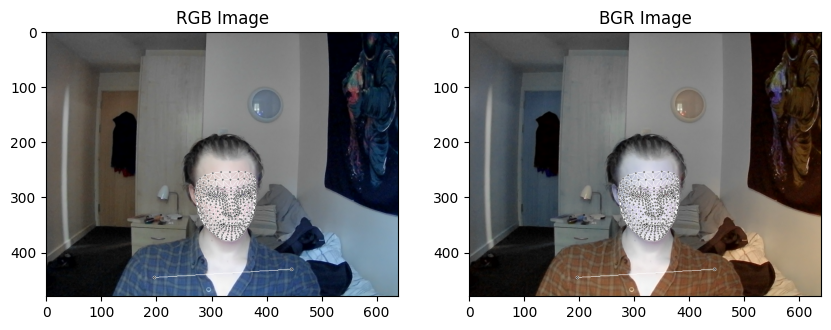

In [45]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("RGB Image")
plt.imshow(rgb_frame)

plt.subplot(1, 2, 2)
plt.title("BGR Image")
plt.imshow(bgr_frame)

plt.show()


In [46]:
DATA_PATH = os.path.join('GestureData')

# Gesture that will be detected 
gestures = np.array(['Hello', 'Good', 'Morning', 'Afternoon', 'Night', 'Thanks', 'Sorry', 'How are you'])
%store gestures

#new_gesture = ['How are you']

# Number of sequences of data
n_frames = 15
# number of frames in each sequence 
length_frames = 20

augmentation_pipeline = A.Compose([
    A.GaussianBlur(p=0.2),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.ChannelShuffle(p=0.5),
    A.InvertImg(p=0.5),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5)
], p=1)

Stored 'gestures' (ndarray)


In [47]:
import contextlib
for gesture in gestures:
    for frame in range(n_frames):
        with contextlib.suppress(Exception):
            os.makedirs(os.path.join(DATA_PATH, gesture, str(frame)))

In [ ]:
#import contextlib
#for gesture in new_gesture:
    #for frame in range(n_frames):
        #with contextlib.suppress(Exception):
            #os.makedirs(os.path.join(DATA_PATH, gesture, str(frame)))

In [48]:
def find_next_video_number(gesture_folder):
    video_numbers = [int(folder) for folder in os.listdir(gesture_folder) if folder.isdigit()]
    return max(video_numbers) + 1 if video_numbers else 0

cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # Loop through gestures
    for gesture in gestures:
        gesture_path = os.path.join(DATA_PATH, gesture)
        start_video = find_next_video_number(gesture_path)

        # Loop through sequence
        for video in range(start_video, start_video + n_frames):
            # Create folder for new video
            os.makedirs(os.path.join(gesture_path, str(video)))

            # Loop through length of frames captured
            for frame_num in range(length_frames):

                # Read feed
                ret, input_frame = cap.read()

                input_image = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
                augmented_image = augmentation_pipeline(image=input_image)['image']

                # Convert the augmented_image back to BGR format
                augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)

                # Make detections using the augmented_image
                input_image, results = mediapipe_detection(augmented_image, holistic)

                # Draw landmarks
                draw_styled_landmarks(input_image, results)

                # Apply waiting time between each data sequence
                if frame_num == 0: 
                    cv2.putText(input_image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255, 255), 1, cv2.LINE_AA)
                    cv2.putText(
                        input_image,
                        f'Collecting frames for {gesture} Video Number {video}',
                        (15, 12),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (255, 255, 255),
                        1,
                        cv2.LINE_AA,
                    )
                    # Open to screen
                    cv2.imshow('OpenCV Feed', input_image)

                    # Two second wait time
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(
                        input_image,
                        f'Collecting frames for {gesture} Video Number {video}',
                        (15, 12),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (255, 255, 255),
                        1,
                        cv2.LINE_AA,
                    )
                    # Open to screen
                    cv2.imshow('OpenCV Feed', input_image)

                # Export new keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, gesture, str(video), str(frame_num))
                np.save(npy_path, keypoints)

                # Press q to break
                if cv2.waitKey(10) & 0xFF == ord('q'):

                    break
    cap.release()
    cv2.destroyAllWindows()              

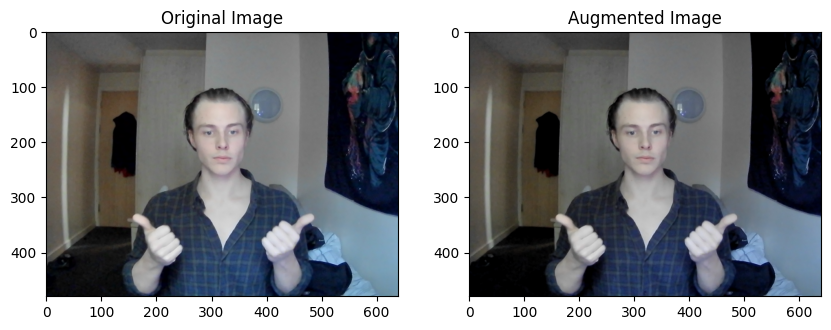

In [49]:
last_input_frame_rgb = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
last_augmented_image = augmentation_pipeline(image=last_input_frame_rgb)['image']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(last_input_frame_rgb)
ax[0].set_title("Original Image")
ax[1].imshow(last_augmented_image)
ax[1].set_title("Augmented Image")
plt.show()